In [3]:
!nvidia-smi -q


==============NVSMI LOG==============

Timestamp                                 : Fri Feb  6 17:48:03 2026
Driver Version                            : 550.54.15
CUDA Version                              : 12.4

Attached GPUs                             : 1
GPU 00000000:00:04.0
    Product Name                          : Tesla T4
    Product Brand                         : NVIDIA
    Product Architecture                  : Turing
    Display Mode                          : Enabled
    Display Active                        : Disabled
    Persistence Mode                      : Disabled
    Addressing Mode                       : None
    MIG Mode
        Current                           : N/A
        Pending                           : N/A
    Accounting Mode                       : Disabled
    Accounting Mode Buffer Size           : 4000
    Driver Model
        Current                           : N/A
        Pending                           : N/A
    Serial Number                 

In [8]:
import os
from subprocess import run, PIPE

cuda_filename = 'levenshtein_cuda.cu'
library_name = 'levenshtein_lib.so'

cuda_code = """
#include <iostream>
#include <chrono>
#include <map>
#include <vector>
#include <string>
#include <algorithm>
#include <ctime>
#include <cstdlib>
#include <cstring>
#include <fstream>
#include <cuda_runtime.h>
#include <cooperative_groups.h>

namespace cg = cooperative_groups;

#define nTests 10

//random word generation
std::string generateWord(int n) {
    std::string word = "";
    for (int i = 0; i < n; i++) word += (char)('a' + rand() % 26);
    return word;
}

int sequentialDistance(std::string A, std::string B) {
    int lenA = A.size();
    int lenB = B.size();
    std::vector<int> prev(lenB + 1);
    std::vector<int> curr(lenB + 1);
    for (int j = 0; j <= lenB; j++) prev[j] = j;
    for (int i = 1; i <= lenA; i++) {
        curr[0] = i;
        for (int j = 1; j <= lenB; j++) {
            int cost = (A[i - 1] == B[j - 1]) ? 0 : 1;
            curr[j] = std::min({curr[j - 1] + 1, prev[j] + 1, prev[j - 1] + cost});
        }
        prev = curr;
    }
    return prev[lenB];
}

//initialize matrix edges directly on GPU
__global__ void initLevenshteinMatrix(int *matrix, int len1, int len2) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    int cols = len2 + 1;

    //initialize first row [0][j] = j
    if (idx <= len2) {
        matrix[idx] = idx;
    }

    //initialize first column [i][0] = i
    if (idx <= len1) {
        matrix[idx * cols] = idx;
    }
}

__global__ void levKernelCooperative(const char *s1, const char *s2, int len1, int len2, int *matrix) {
    cg::grid_group grid = cg::this_grid();

    int total_threads = gridDim.x * blockDim.x;
    int tid = blockIdx.x * blockDim.x + threadIdx.x;
    int cols = len2 + 1;

    //cycle on diagonals - wavefront
    for (int k = 2; k <= (len1 + len2); ++k) {
        int i_start = max(1, k - len2);
        int i_end = min(len1, k - 1);
        int diag_size = i_end - i_start + 1;

        for (int idx = tid; idx < diag_size; idx += total_threads) {
            int i = i_start + idx;
            int j = k - i;

            int cost = (s1[i - 1] == s2[j - 1]) ? 0 : 1;

            int current_idx = i * cols + j;
            int up          = (i - 1) * cols + j;
            int left        = i * cols + (j - 1);
            int diag        = (i - 1) * cols + (j - 1);

            int res = matrix[up] + 1;
            if (matrix[left] + 1 < res) res = matrix[left] + 1;
            if (matrix[diag] + cost < res) res = matrix[diag] + cost;

            matrix[current_idx] = res;
        }
        grid.sync();
    }
}

extern "C" int parallelDistance(const char *h_s1, const char *h_s2, int len1, int len2, int threadsPerBlock) {
    int *d_matrix;
    char *d_s1, *d_s2;
    int size1 = len1 + 1;
    int size2 = len2 + 1;
    size_t matrix_elements = (size_t)size1 * size2;
    size_t matrix_bytes = matrix_elements * sizeof(int);

    cudaMalloc(&d_matrix, matrix_bytes);
    cudaMalloc(&d_s1, len1);
    cudaMalloc(&d_s2, len2);

    cudaMemcpy(d_s1, h_s1, len1, cudaMemcpyHostToDevice);
    cudaMemcpy(d_s2, h_s2, len2, cudaMemcpyHostToDevice);

    //initializing matrix on GPU
    int max_dim = (len1 > len2) ? len1 : len2;
    int initBlocks = (max_dim + 255) / 256;
    initLevenshteinMatrix<<<initBlocks, 256>>>(d_matrix, len1, len2);
    cudaDeviceSynchronize(); // Opzionale, solo per sicurezza prima del kernel pesante

    //calculation cooperative
    int numBlocksPerSM;
    cudaOccupancyMaxActiveBlocksPerMultiprocessor(&numBlocksPerSM, levKernelCooperative, threadsPerBlock, 0);
    int device;
    cudaGetDevice(&device);
    cudaDeviceProp prop;
    cudaGetDeviceProperties(&prop, device);
    int totalBlocks = numBlocksPerSM * prop.multiProcessorCount;

    void* args[] = { (void*)&d_s1, (void*)&d_s2, (void*)&len1, (void*)&len2, (void*)&d_matrix };
    cudaLaunchCooperativeKernel((void*)levKernelCooperative, totalBlocks, threadsPerBlock, args);

    cudaDeviceSynchronize();

    int result = 0;
    cudaMemcpy(&result, &d_matrix[matrix_elements - 1], sizeof(int), cudaMemcpyDeviceToHost);

    cudaFree(d_matrix); cudaFree(d_s1); cudaFree(d_s2);
    return result;
}

extern "C" void free_cuda_memory(void* ptr) { delete[] (float*)ptr; }

extern "C" float* run_tests(const int* sizes, int n_sizes, const int* blockSizes, int n_blockSizes) {
    srand(time(NULL));

    float* output = new float[n_sizes + 2 * (n_sizes * n_blockSizes)];
    int out_ptr = 0;
    std::vector<float> seq_times;
    std::map<int, std::vector<float>> par_times;

    for (int i = 0; i < n_sizes; i++) {
        int n = sizes[i];
        std::vector<std::string> Awords, Bwords;
        std::vector<int> lensA, lensB;


        for (int j = 0; j < nTests; j++) {
            std::string a = generateWord(n);
            std::string b = generateWord(n / 2 + rand() % n);

            Awords.push_back(a);
            Bwords.push_back(b);
            lensA.push_back(a.length());
            lensB.push_back(b.length());

        }

        auto s_seq = std::chrono::high_resolution_clock::now();
        std::vector<int> cpu_res(nTests);
        for (int j = 0; j < nTests; j++) cpu_res[j] = sequentialDistance(Awords[j], Bwords[j]);
        auto e_seq = std::chrono::high_resolution_clock::now();
        seq_times.push_back(std::chrono::duration<float, std::milli>(e_seq - s_seq).count() / nTests);

        for (int k = 0; k < n_blockSizes; k++) {
            int bs = blockSizes[k];
            auto s_par = std::chrono::high_resolution_clock::now();
            for (int j = 0; j < nTests; j++) {
                int gpu_res = parallelDistance(Awords[j].c_str(), Bwords[j].c_str(), lensA[j], lensB[j], bs);
            }
            auto e_par = std::chrono::high_resolution_clock::now();
            par_times[bs].push_back(std::chrono::duration<float, std::milli>(e_par - s_par).count() / nTests);
        }
    }

    for (float t : seq_times) output[out_ptr++] = t;
    for (int k = 0; k < n_blockSizes; k++)
        for (float t : par_times[blockSizes[k]]) output[out_ptr++] = t;
    for (int k = 0; k < n_blockSizes; k++)
        for (int i = 0; i < n_sizes; i++) output[out_ptr++] = seq_times[i] / par_times[blockSizes[k]][i];

    return output;
}
"""

with open(cuda_filename, 'w') as f:
    f.write(cuda_code)

compile_command = f"nvcc -o {library_name} {cuda_filename} -shared -Xcompiler -fPIC -std=c++11"
result = run(compile_command, shell=True, stdout=PIPE, stderr=PIPE)
if result.returncode != 0:
    print("ERRORE COMPILAZIONE!")
    print(result.stderr.decode())
else:
    print(f"Libreria '{library_name}' creata correttamente.")


Libreria 'levenshtein_lib.so' creata correttamente.


In [10]:
import numpy as np
import ctypes
from ctypes import c_int, POINTER, c_float

library_name = 'levenshtein_lib.so'

#load library
cuda_lib = ctypes.CDLL(f"./{library_name}")

cuda_lib.run_tests.argtypes = [
    POINTER(c_int),
    c_int,
    POINTER(c_int),
    c_int
]
cuda_lib.run_tests.restype = POINTER(c_float)

cuda_lib.free_cuda_memory.argtypes = [ctypes.c_void_p]
cuda_lib.free_cuda_memory.restype = None

x_axes = np.array([100, 1000, 5000, 10000, 20000, 40000], dtype=np.int32)
blockSizes = np.array([32, 64, 128, 256, 512, 1024], dtype=np.int32)

result_ptr = cuda_lib.run_tests(
    x_axes.ctypes.data_as(POINTER(c_int)),
    c_int(len(x_axes)),
    blockSizes.ctypes.data_as(POINTER(c_int)),
    c_int(len(blockSizes))
)

total_expected_results = len(x_axes) * (1 + 2 * len(blockSizes))
results_array = np.asarray(result_ptr[:total_expected_results])
cuda_lib.free_cuda_memory(result_ptr)

#organization of results
seq_times = results_array[0 : len(x_axes)]
current_idx = len(x_axes)

times = {'Sequential': seq_times.tolist()}
for bs in blockSizes:
    key = f'{bs} block size'
    times[key] = results_array[current_idx : current_idx + len(x_axes)].tolist()
    current_idx += len(x_axes)

speedups = {}
for bs in blockSizes:
    key = f'{bs} block size'
    speedups[key] = results_array[current_idx : current_idx + len(x_axes)].tolist()
    current_idx += len(x_axes)

print("Tempi (ms):", times)
print("Speedup (x):", speedups)

Tempi (ms): {'Sequential': [0.5808998346328735, 49.633018493652344, 1552.161376953125, 4543.6142578125, 23549.47265625, 74445.1328125], '32 block size': [0.6636016964912415, 0.635185718536377, 2.107940912246704, 3.909656524658203, 21.408071517944336, 109.18952941894531], '64 block size': [0.29522520303726196, 0.591222882270813, 2.1189959049224854, 4.029484748840332, 40.87310028076172, 128.7587432861328], '128 block size': [0.2819482088088989, 0.6024144291877747, 2.1191956996917725, 4.0308518409729, 40.453453063964844, 126.59442138671875], '256 block size': [0.28080299496650696, 0.611519455909729, 2.118875741958618, 4.02906608581543, 43.705970764160156, 126.63126373291016], '512 block size': [0.2797415852546692, 0.5915244817733765, 2.3294460773468018, 4.028741836547852, 36.255069732666016, 126.79793548583984], '1024 block size': [0.29348230361938477, 0.5988398194313049, 2.119807720184326, 8.324701309204102, 44.02061462402344, 126.67647552490234]}
Speedup (x): {'32 block size': [0.875374

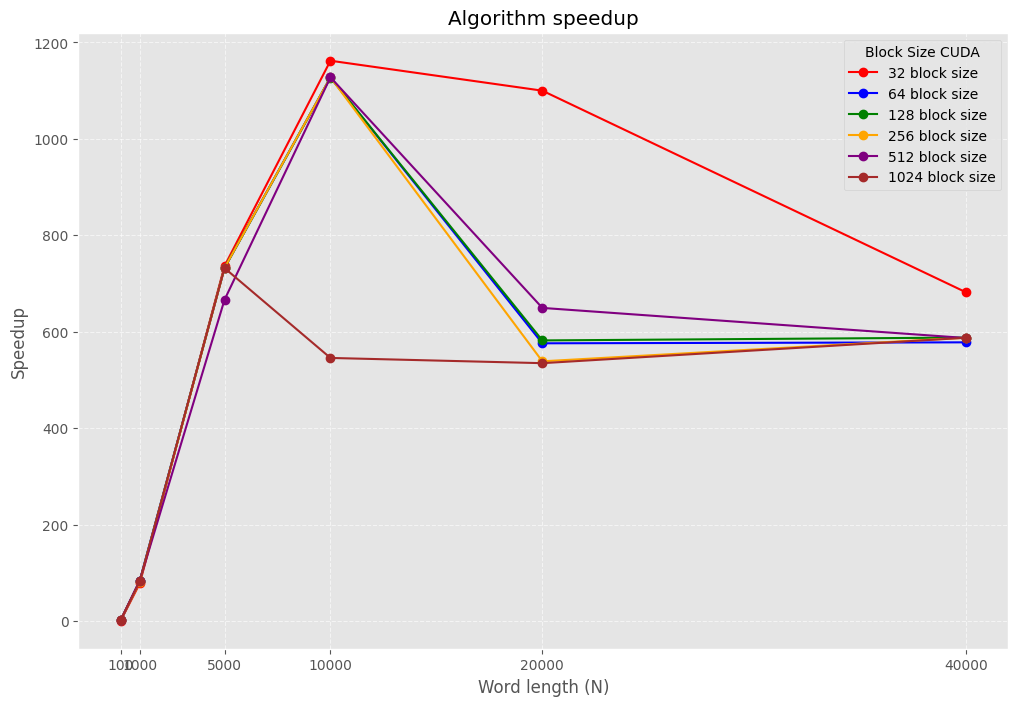

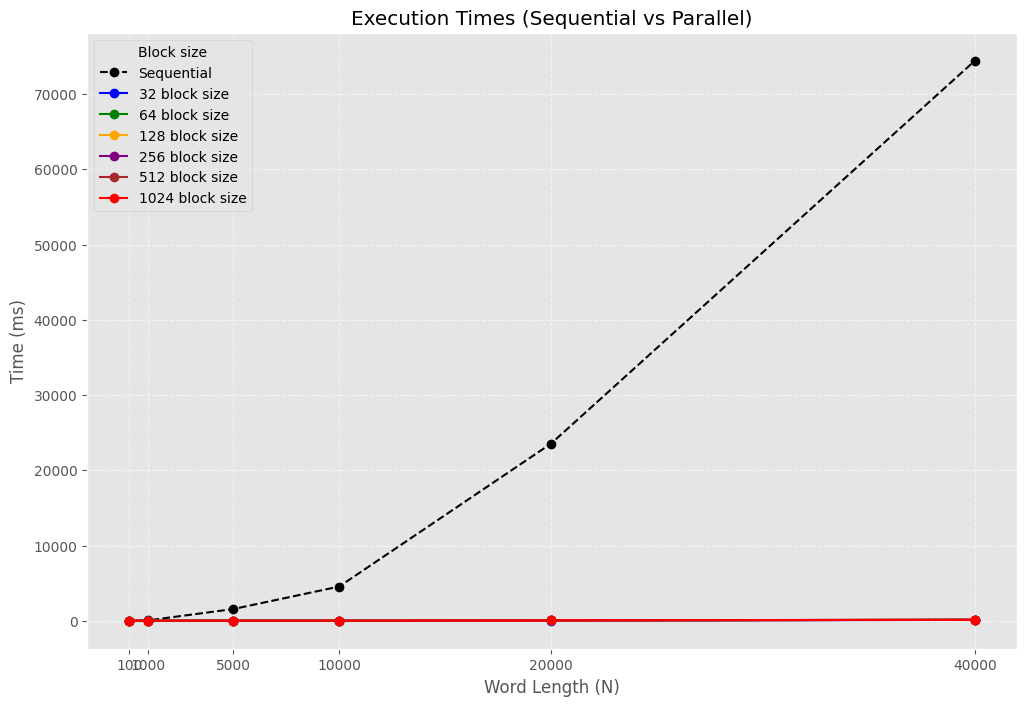

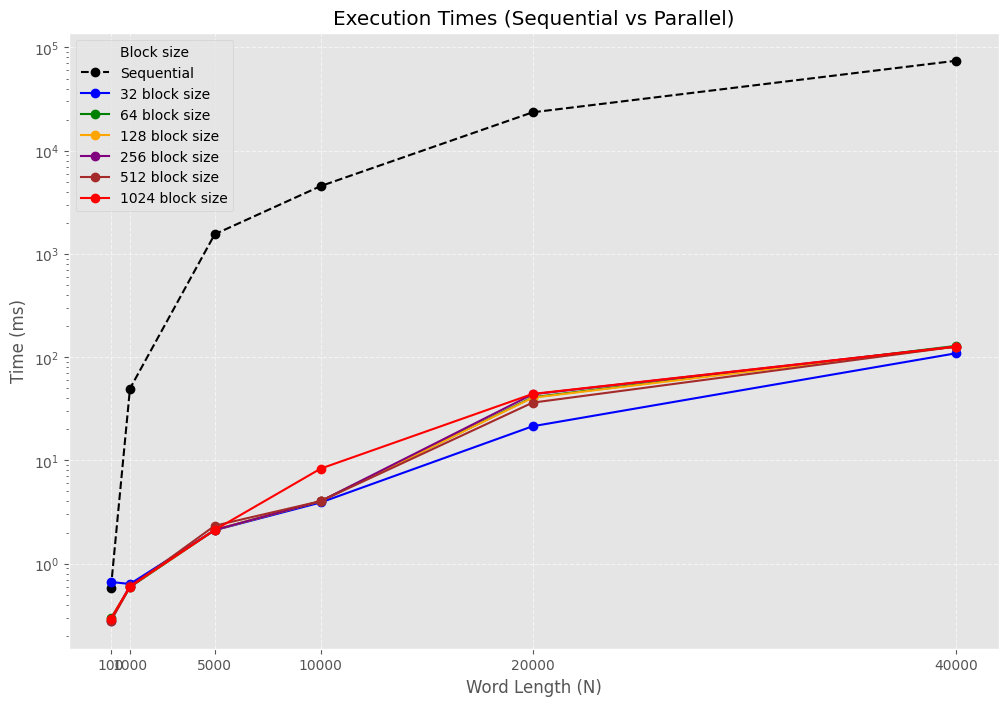

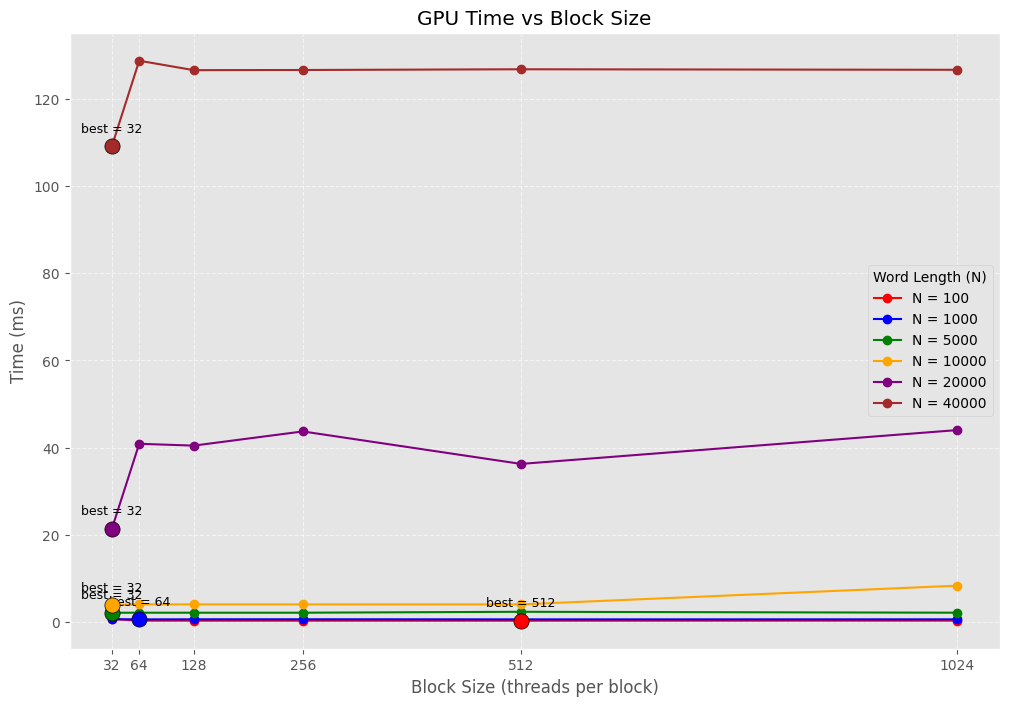

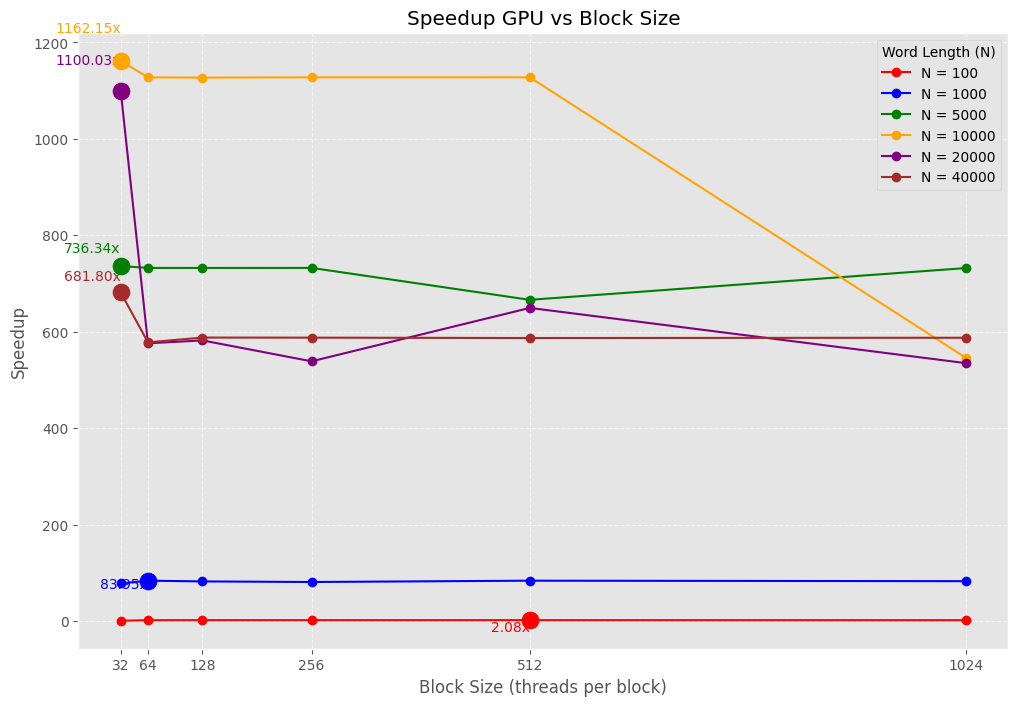

In [12]:
import matplotlib.pyplot as plt

colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']

#speedup graph
plt.figure(figsize=(12, 8))
plt.style.use('ggplot')
for idx, (key, speedup) in enumerate(speedups.items()):
    plt.plot(x_axes, speedup, label=key, color=colors[idx % len(colors)], marker='o')

plt.title("Algorithm speedup")
plt.xlabel("Word length (N)")
plt.xticks(x_axes)
plt.ylabel("Speedup")
plt.legend(title="Block Size CUDA")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

#time graph
plt.figure(figsize=(12, 8))
all_times_keys = list(times.keys())
for idx, key in enumerate(all_times_keys):
    time_values = times[key]
    color = 'black' if 'Sequential' in key else colors[idx % len(colors)]
    style = 'dashed' if 'Sequential' in key else 'solid'
    plt.plot(x_axes, time_values, label=key, color=color, linestyle=style, marker='o')

plt.title("Execution Times (Sequential vs Parallel)")
plt.xlabel("Word Length (N)")
plt.xticks(x_axes)
plt.ylabel("Time (ms)")
plt.legend(title="Block size")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

#time graph log
plt.figure(figsize=(12, 8))
all_times_keys = list(times.keys())
for idx, key in enumerate(all_times_keys):
    time_values = times[key]
    color = 'black' if 'Sequential' in key else colors[idx % len(colors)]
    style = 'dashed' if 'Sequential' in key else 'solid'
    plt.plot(x_axes, time_values, label=key, color=color, linestyle=style, marker='o')

plt.title("Execution Times (Sequential vs Parallel)")
plt.xlabel("Word Length (N)")
plt.xticks(x_axes)
plt.ylabel("Time (ms)")
plt.legend(title="Block size")
plt.grid(True, linestyle='--', alpha=0.6)
plt.yscale('log')
plt.show()

######################################à
##### altro grafico #####

plt.figure(figsize=(12, 8))
plt.style.use('ggplot')

for i, N in enumerate(x_axes):
    par_times_for_N = [
        times[f'{bs} block size'][i] for bs in blockSizes
    ]

    par_times_for_N = np.array(par_times_for_N)

    #best block size
    min_idx = np.argmin(par_times_for_N)
    best_bs = blockSizes[min_idx]
    best_time = par_times_for_N[min_idx]

    plt.plot(
        blockSizes,
        par_times_for_N,
        marker='o',
        color=colors[i % len(colors)],
        label=f'N = {N}'
    )

    #highlight minimum
    plt.scatter(
        best_bs,
        best_time,
        s=120,
        color=colors[i % len(colors)],
        edgecolors='black',
        zorder=5
    )

    plt.annotate(
        f'best = {best_bs}',
        (best_bs, best_time),
        textcoords="offset points",
        xytext=(0, 10),
        ha='center',
        fontsize=9
    )

plt.title('GPU Time vs Block Size')
plt.xlabel('Block Size (threads per block)')
plt.ylabel('Time (ms)')
plt.xticks(blockSizes)
plt.legend(title='Word Length (N)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

########### altro grafico ###############

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.style.use('ggplot')

for i, N in enumerate(x_axes):
    speedup_for_N = []

    for bs in blockSizes:
        key = f'{bs} block size'
        speedup_for_N.append(speedups[key][i])

    line_color = colors[i % len(colors)]

    plt.plot(
        blockSizes,
        speedup_for_N,
        marker='o',
        color=line_color,
        label=f'N = {N}'
    )

    #highlight the maximum speedup
    max_idx = speedup_for_N.index(max(speedup_for_N))
    plt.scatter(
        blockSizes[max_idx],
        speedup_for_N[max_idx],
        color=line_color,
        s=150,
        zorder=5
    )

    #text above the maximum
    plt.text(
        blockSizes[max_idx] - 0.05,
        speedup_for_N[max_idx] + 0.07 * max(speedup_for_N),
        f"{speedup_for_N[max_idx]:.2f}x",
        ha='right',
        va='top',
        fontsize=10,
        color=line_color
    )

plt.title('Speedup GPU vs Block Size')
plt.xlabel('Block Size (threads per block)')
plt.ylabel('Speedup')
plt.xticks(blockSizes)
plt.legend(title='Word Length (N)', loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

